# **Cross-Validation Training on Dataset 02 for Binary SQL Injection Detection**

**We implements and evaluates three machine learning models (Random Forest, Naive Bayes, and SVC) for SQL injection detection using the RbSQLi dataset. The pipeline includes data preprocessing, TF-IDF vectorization, hyperparameter tuning via GridSearchCV with 5-fold cross-validation, and comprehensive model evaluation. The Naive Bayes classifier achieved the best performance with 70.50% accuracy and an F1-score of 0.7653 for malicious queries, outperforming both Random Forest (58.65% accuracy) and SVC (51.10% accuracy).**

### 📊 Dataset Overview

- **Training Dataset**: Custom SQL Injection Dataset  
  - Total Samples: **18,000**
  - Class Distribution:
    - SQL Injection (Malicious): **9,000**
    - Normal (Non-Malicious): **9,000**

- **Testing Dataset**: [SQL Injection Dataset](https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset)
  - Total Samples: **2,000**
  - Class Distribution:
    - SQL Injection (Malicious): **1,000**
    - Normal (Non-Malicious): **1,000**


# **Random Forest**

/tmp/ipykernel_36/1655192410.py:30: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 300}
Test Accuracy: 0.5865
Classification Report:
               precision    recall  f1-score   support

           0     0.6720    0.3380    0.4498      1000
           1     0.5578    0.8350    0.6688      1000

    accuracy                         0.5865      2000
   macro avg     0.6149    0.5865    0.5593      2000
weighted avg     0.6149    0.5865    0.5593      2000



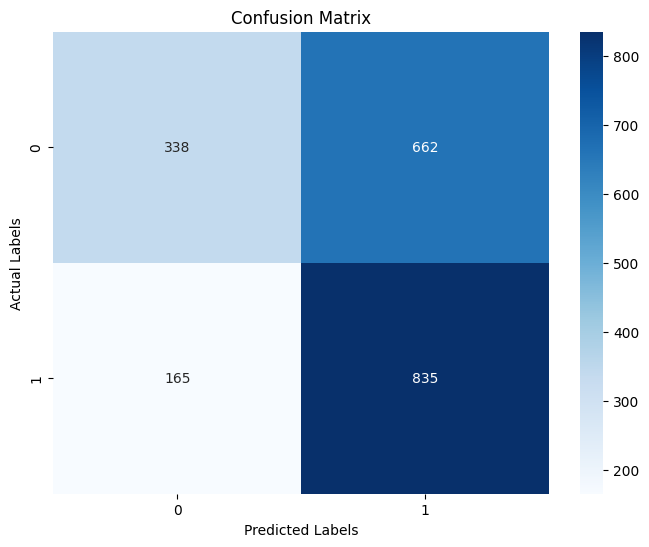

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as snsA
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# 1. Load datasets
df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")
df_test  = pd.read_csv("/kaggle/input/sql-injection-dataset/SQLiV3.csv")

# 2. Drop missing values in critical columns
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Sentence', 'Label'], inplace=True)

# 3. Rename columns
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Sentence': 'text', 'Label': 'label'}, inplace=True)

# 4. Map and convert labels
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Create balanced training & testing datasets
df_train_0 = df_train[df_train.label == 0].sample(9000, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(9000, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(1000, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(1000, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Extract features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test   = df_test_bal['text'], df_test_bal['label']

# 7. Build pipeline with TF-IDF + RandomForest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 8. Hyperparameter grid for RandomForest
param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__max_features': ['sqrt', 'log2']
}

# 9. 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best params and score
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


# **Naive Bayes**

/tmp/ipykernel_36/2874738781.py:30: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__min_df': 1, 'tfidf__use_idf': True}
Test Accuracy: 0.7050
Classification Report:
               precision    recall  f1-score   support

           0     0.9218    0.4480    0.6030      1000
           1     0.6354    0.9620    0.7653      1000

    accuracy                         0.7050      2000
   macro avg     0.7786    0.7050    0.6841      2000
weighted avg     0.7786    0.7050    0.6841      2000



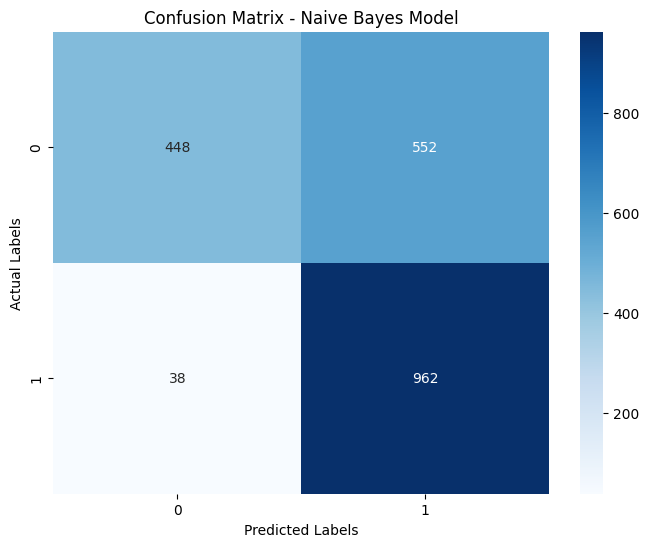


Most Informative Features:
Top 20 features for class 0 (non-malicious):
  01 (-11.1317)
  order_id (-10.5990)
  safe (-10.5694)
  pending (-10.5525)
  shipped (-10.5402)
  in (-10.4998)
  test example (-10.4967)
  com (-10.4967)
  example (-10.4967)
  example com (-10.4967)
  between (-10.4417)
  2024 01 (-10.4386)
  01 01 (-10.4386)
  2024 (-10.4386)
  where created_at (-9.9669)
  where status (-9.9527)
  where user_id (-9.9404)
  where product_id (-9.9384)
  where price (-9.9293)
  where email (-9.9233)

Top 20 features for class 1 (malicious):
  username admin (9.4115)
  3409 3409 (9.4321)
  where username (9.4453)
  or 3409 (9.4645)
  union (9.6149)
  union select (9.6149)
  null null (9.7119)
  set (9.7872)
  id order (9.8967)
  not order (9.9270)
  or order (9.9383)
  like order (9.9516)
  and order (10.0009)
  username (10.0530)
  sleep (10.0929)
  3409 (10.1381)
  exec select (10.2941)
  order by (11.0774)
  order (11.0774)
  by (11.0774)


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# 1. Load datasets
df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")
df_test  = pd.read_csv("/kaggle/input/sql-injection-dataset/SQLiV3.csv")

# 2. Drop missing values in critical columns
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Sentence', 'Label'], inplace=True)

# 3. Rename columns
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Sentence': 'text', 'Label': 'label'}, inplace=True)

# 4. Map and convert labels
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Create balanced training & testing datasets
df_train_0 = df_train[df_train.label == 0].sample(9000, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(9000, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(1000, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(1000, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Extract features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test   = df_test_bal['text'], df_test_bal['label']

# 7. Build pipeline with TF-IDF + Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
    ('clf', MultinomialNB())
])

# 8. Hyperparameter grid for Naive Bayes
param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'tfidf__use_idf': [True, False],
    'tfidf__min_df': [1, 2, 3]
}

# 9. 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best params and score
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Naive Bayes Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
# 14. Extracting the most informative features for Naive Bayes (top features per class)
def get_most_informative_features(vectorizer, classifier, n=20):
    feature_names = vectorizer.get_feature_names_out()
    if len(classifier.classes_) == 2:
        class_0 = classifier.classes_[0]
        class_1 = classifier.classes_[1]
        log_proba_diffs = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
        top_indices = np.argsort(log_proba_diffs)
        print(f"Top {n} features for class {class_0} (non-malicious):")
        for i in top_indices[:n]:
            print(f"  {feature_names[i]} ({log_proba_diffs[i]:.4f})")
        print(f"\nTop {n} features for class {class_1} (malicious):")
        for i in top_indices[-n:]:
            print(f"  {feature_names[i]} ({log_proba_diffs[i]:.4f})")
vectorizer = best_model.named_steps['tfidf']
classifier = best_model.named_steps['clf']
print("\nMost Informative Features:")
get_most_informative_features(vectorizer, classifier)

# **SVC**

/tmp/ipykernel_36/2292496840.py:30: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")


Starting grid search with SVC model...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV F1 Score: 1.0
Best Parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear', 'tfidf__max_df': 0.5}
Fitting the best model on the full training set...
Test Accuracy: 0.5110
Classification Report:
               precision    recall  f1-score   support

           0     0.6618    0.0450    0.0843      1000
           1     0.5057    0.9770    0.6664      1000

    accuracy                         0.5110      2000
   macro avg     0.5837    0.5110    0.3754      2000
weighted avg     0.5837    0.5110    0.3754      2000



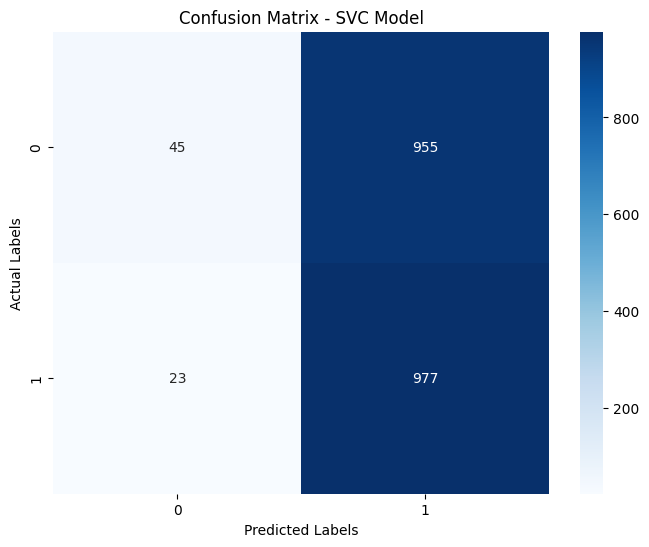


Most Important Features:
Top 20 features for NON-malicious (class 0):
  where product_id (-1.0360)
  where user_id (-1.0391)
  where status (-1.0918)
  where price (-1.1017)
  where created_at (-1.1326)
  status (-1.1524)
  price (-1.1876)
  created_at (-1.1964)
  updated_at (-1.2089)
  product_id (-1.2176)
  user_id (-1.2208)
  not id (-1.3070)
  active (-1.3705)
  email (-1.3870)
  pending (-1.4004)
  order_id (-1.4290)
  safe (-1.4647)
  shipped (-1.4722)
  and id (-1.5591)
  or id (-1.7980)

Top 20 features for malicious (class 1):
  select (1.9641)
  id or (1.5214)
  id and (1.2183)
  sleep (0.9013)
  null null (0.8790)
  id not (0.8644)
  having (0.8488)
  select user_id (0.7938)
  pg_sleep (0.7819)
  select created_at (0.7016)
  order (0.6913)
  by (0.6913)
  order by (0.6913)
  username (0.6748)
  select price (0.6392)
  randomblob (0.6335)
  set (0.6330)
  where and (0.5919)
  id like (0.5903)
  union (0.5734)


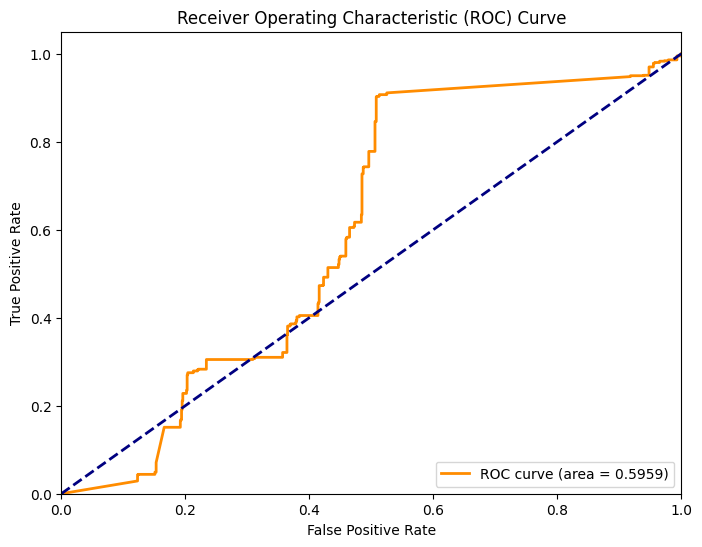

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# 1. Load datasets
df_train = pd.read_csv("/kaggle/input/rbsqli-a-rule-based-sql-injection-dataset/sql_injectiondataset_final_updated.csv")
df_test  = pd.read_csv("/kaggle/input/sql-injection-dataset/SQLiV3.csv")

# 2. Drop missing values in critical columns
df_train.dropna(subset=['sql_query', 'vulnerability_status'], inplace=True)
df_test.dropna(subset=['Sentence', 'Label'], inplace=True)

# 3. Rename columns
df_train.rename(columns={'sql_query': 'text', 'vulnerability_status': 'label'}, inplace=True)
df_test.rename(columns={'Sentence': 'text', 'Label': 'label'}, inplace=True)

# 4. Map and convert labels
df_train['label'] = df_train['label'].map({'Yes': 1, 'No': 0})
df_train.dropna(subset=['label'], inplace=True)
df_train['label'] = df_train['label'].astype(int)

df_test['label'] = pd.to_numeric(df_test['label'], errors='coerce')
df_test.dropna(subset=['label'], inplace=True)
df_test['label'] = df_test['label'].astype(int)

# 5. Create balanced training & testing datasets
df_train_0 = df_train[df_train.label == 0].sample(9000, random_state=42)
df_train_1 = df_train[df_train.label == 1].sample(9000, random_state=42)
df_train_bal = pd.concat([df_train_0, df_train_1]).sample(frac=1, random_state=42)

df_test_0 = df_test[df_test.label == 0].sample(1000, random_state=42)
df_test_1 = df_test[df_test.label == 1].sample(1000, random_state=42)
df_test_bal = pd.concat([df_test_0, df_test_1]).sample(frac=1, random_state=42)

# 6. Extract features and labels
X_train, y_train = df_train_bal['text'], df_train_bal['label']
X_test, y_test   = df_test_bal['text'], df_test_bal['label']

# 7. Build pipeline with TF-IDF + Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=20000)),
    ('clf', MultinomialNB())
])

# 8. Hyperparameter grid for Naive Bayes
param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False],
    'tfidf__use_idf': [True, False],
    'tfidf__min_df': [1, 2, 3]
}

# 9. 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 10. GridSearchCV to find best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 11. Output best params and score
print("Best CV F1 Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 12. Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Naive Bayes Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
# 14. Extracting the most informative features for Naive Bayes (top features per class)
def get_most_informative_features(vectorizer, classifier, n=20):
    feature_names = vectorizer.get_feature_names_out()
    if len(classifier.classes_) == 2:
        class_0 = classifier.classes_[0]
        class_1 = classifier.classes_[1]
        log_proba_diffs = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
        top_indices = np.argsort(log_proba_diffs)
        print(f"Top {n} features for class {class_0} (non-malicious):")
        for i in top_indices[:n]:
            print(f"  {feature_names[i]} ({log_proba_diffs[i]:.4f})")
        print(f"\nTop {n} features for class {class_1} (malicious):")
        for i in top_indices[-n:]:
            print(f"  {feature_names[i]} ({log_proba_diffs[i]:.4f})")
vectorizer = best_model.named_steps['tfidf']
classifier = best_model.named_steps['clf']
print("\nMost Informative Features:")
get_most_informative_features(vectorizer, classifier)